# Week 1-4 - Reflection

# Week 1 Reflection

1. In Coding Quiz 1, you are asked to find the distance of the farthest match in a set.  Is this farthest match distance too far to be a meaningful match?  How can you decide this?

A distance of 0.21 means the farthest “match” is relatively dissimilar compared to closer matches. To say whether it’s meaningful, we will will compare it to the distribution of all match distances or use a domain-specific threshold. Often, such a farthest match is less reliable and might be excluded from “true matches.”

The Z-distance distribution:

- mean distance ≈ 0.0498

- median ≈ 0.0133

- 90th percentile ≈ 0.1722

- max (farthest) ≈ 0.2102 ← the correct answer

- sd(Z) ≈ 0.2898

Is 0.2102 “too far”?

Use a caliper rule of thumb:

0.2 × sd(Z) ≈ 0.058

(even a loose) 0.5 × sd(Z) ≈ 0.145

The farthest match 0.2102 is > 0.5 sd and well above 0.2 sd, and it’s also much larger than the mean/median distances. So yes—it’s too far to be a reliable match and should be dropped or re-matched with a caliper.

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Tiny helper for printing distance summaries
def summarize_distances(d):
    d = np.asarray(d, dtype=float)
    return {
        "n": int(d.size),
        "mean": float(d.mean()) if d.size else np.nan,
        "median": float(np.median(d)) if d.size else np.nan,
        "max": float(d.max()) if d.size else np.nan,
        "q90": float(np.quantile(d, 0.90)) if d.size else np.nan,
    }

In [2]:
# Load data from GitHub raw URLs ===
URL_12 = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/refs/heads/main/homework_1.2.csv"
URL_11 = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/refs/heads/main/homework_1.1.csv"

df12 = pd.read_csv(URL_12)  # expects columns: X, Y, Z
df11 = pd.read_csv(URL_11)  # (used elsewhere in course) columns: X1, X2, X3, Y

display(df12.head())
display(df11.head())

assert {"X","Y","Z"}.issubset(df12.columns), "homework_1.2.csv must contain columns X, Y, Z"

,X,Y,Z
0,0,0.548814,0.548814
1,1,1.215189,0.715189
2,0,0.602763,0.602763
3,0,0.544883,0.544883
4,0,0.423655,0.423655


,X1,X2,X3,Y
0,-0.440646,-0.390227,0.156718,-0.877671
1,-3.810099,-1.304665,-1.105117,-10.130388
2,-1.425451,-0.340049,1.115908,0.284068
3,-1.325750,0.161906,-0.254670,-1.994344
4,3.120263,1.487343,-1.164839,2.030030


In [3]:
# Function: 1-NN matching on Z with caliper = c * sd(Z)
def nn_match_with_caliper(df, caliper_mult=0.2, out_prefix="nn"):
    """
    df            : DataFrame with columns X (0/1), Y, Z
    caliper_mult  : caliper = caliper_mult * sd(Z)  (default 0.2)
    out_prefix    : prefix for saved CSVs
    Returns: kept_pairs_df, dropped_pairs_df, summary_dict
    """
    assert {"X","Y","Z"}.issubset(df.columns), "Need columns X, Y, Z"
    treated = (df[df["X"]==1].copy()
                 .reset_index(drop=False)
                 .rename(columns={"index":"orig_idx_t"}))
    control = (df[df["X"]==0].copy()
                 .reset_index(drop=False)
                 .rename(columns={"index":"orig_idx_c"}))

    if treated.empty or control.empty:
        raise ValueError("Both treated (X=1) and control (X=0) groups are required.")

    # Fit NN on controls using Z only (1-D)
    nn = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(control[["Z"]])
    distances, indices = nn.kneighbors(treated[["Z"]])
    distances = distances.ravel()
    indices = indices.ravel()

    matched_ctrl = control.iloc[indices].reset_index(drop=True)

    pairs = pd.DataFrame({
        "treated_idx": treated["orig_idx_t"].to_numpy(),
        "control_idx": matched_ctrl["orig_idx_c"].to_numpy(),
        "Z_treated": treated["Z"].to_numpy(),
        "Z_control": matched_ctrl["Z"].to_numpy(),
        "distance_abs": np.abs(treated["Z"].to_numpy() - matched_ctrl["Z"].to_numpy()),
        "Y_treated": treated["Y"].to_numpy(),
        "Y_control": matched_ctrl["Y"].to_numpy(),
    })

    # Diagnostics BEFORE caliper
    pre_diag = summarize_distances(pairs["distance_abs"])
    sd_z = float(df["Z"].std(ddof=1))
    caliper = caliper_mult * sd_z

    # Apply caliper
    kept = pairs[pairs["distance_abs"] <= caliper].reset_index(drop=True)
    dropped = pairs[pairs["distance_abs"] > caliper].reset_index(drop=True)

    # ATT on matched sample (simple difference in means of Y within pairs)
    att = float((kept["Y_treated"] - kept["Y_control"]).mean()) if len(kept) else np.nan

    # Save outputs
    kept_path = f"{out_prefix}_pairs_caliper.csv"
    drop_path = f"{out_prefix}_pairs_over_caliper.csv"
    kept.to_csv(kept_path, index=False)
    dropped.to_csv(drop_path, index=False)

    summary = {
        "n_total": int(len(df)),
        "n_treated": int(len(treated)),
        "n_control": int(len(control)),
        "sd_Z": sd_z,
        "caliper_mult": caliper_mult,
        "caliper": caliper,
        "pre_match": pre_diag,
        "matched_count": int(len(kept)),
        "dropped_count": int(len(dropped)),
        "prop_matched": float(len(kept) / len(treated)) if len(treated) else np.nan,
        "kept_mean_distance": float(kept["distance_abs"].mean()) if len(kept) else np.nan,
        "kept_median_distance": float(kept["distance_abs"].median()) if len(kept) else np.nan,
        "kept_max_distance": float(kept["distance_abs"].max()) if len(kept) else np.nan,
        "att_matched": att,
        "kept_path": kept_path,
        "dropped_path": drop_path,
    }
    return kept, dropped, summary

In [4]:
# Run matching (adjust caliper_mult if desired)

CALIPER_MULT = 0.2  # try 0.5 to keep more pairs

kept, dropped, summary = nn_match_with_caliper(df12, caliper_mult=CALIPER_MULT, out_prefix="nn")
summary

{'n_total': 100,
 'n_treated': 48,
 'n_control': 52,
 'sd_Z': 0.2897540152400463,
 'caliper_mult': 0.2,
 'caliper': 0.05795080304800926,
 'pre_match': {'n': 48,
  'mean': 0.04978820554626162,
  'median': 0.013260269541804953,
  'max': 0.2102170871093757,
  'q90': 0.17221031913516716},
 'matched_count': 36,
 'dropped_count': 12,
 'prop_matched': 0.75,
 'kept_mean_distance': 0.013911097116295837,
 'kept_median_distance': 0.005884733215612059,
 'kept_max_distance': 0.05446309505014957,
 'att_matched': 0.5053402433314637,
 'kept_path': 'nn_pairs_caliper.csv',
 'dropped_path': 'nn_pairs_over_caliper.csv'}

2. In Coding Quiz 1, there are two approaches to matching: 
(A) Picking the best match X = 0 corresponding to each X = 1 using Z values.
(B) Using radius_neighbors to pick all matches X = 0 within a distance of 0.2 of each X = 1.

Invent your own type of matching similar to 1 and 2 (or look one up on the internet), which has a different way to pick the matches in X = 0.  Clearly explain the approach you invented or found.


Approach : Optimal One-to-One Matching (Hungarian) on Z, with an optional caliper

Idea:
Pair each treated unit (X=1) to a unique control (X=0) so that the total Z-distance across all pairs is minimized. Unlike (A) 1-NN (which matches greedily, possibly reusing the same control many times) and (B) radius_neighbors (which can return many controls per treated or none), this method produces a globally optimal, non-overlapping pairing under a distance objective. Add a caliper (max allowed |Z_t − Z_c|) to prevent bad matches; treated units with no feasible control inside the caliper are dropped.

Why it’s useful:

Enforces no reuse of controls (without replacement).

Minimizes the overall mismatch instead of per-unit greedy choices.

Caliper guards against implausible matches.

We construct a cost matrix of absolute covariate differences between treated and control units and solve a global assignment problem that minimizes the total within-pair distance. Controls are used without replacement, ensuring unique matches. We optionally enforce a caliper so that pairs with  above a threshold are disallowed. Treated units without any feasible control inside the caliper are dropped. Compared to (A) best-single-match and (B) radius neighbors, this approach optimizes match quality globally rather than greedily per treated unit, while still avoiding poor matches via the caliper.

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

def optimal_match_by_Z(df, caliper=None, caliper_is_abs=True, caliper_mult_of_sd=False, z_col="Z"):
    """
    Optimal one-to-one matching between treated (X=1) and controls (X=0) by minimizing
    total |Z_t - Z_c| using the Hungarian algorithm (without replacement).
    
    Parameters
    ----------
    df : pd.DataFrame with columns ['X','Y', z_col]
    caliper : float or None
        - If caliper_is_abs=True: maximum allowed absolute distance |Z_t - Z_c|.
        - If caliper_mult_of_sd=True: interpreted as a multiple of sd(Z) (e.g., 0.2 => 0.2*sd(Z)).
    caliper_is_abs : bool
        If True, `caliper` is an absolute distance threshold in Z-units.
    caliper_mult_of_sd : bool
        If True, `caliper` is multiplied by sd(Z) to compute the absolute threshold.
    z_col : str
        Column name for Z.
    
    Returns
    -------
    matched_pairs : DataFrame with columns:
        ['treated_idx','control_idx','Z_treated','Z_control','distance_abs','Y_treated','Y_control']
    dropped_treated_idx : list of original treated indices that could not be matched within caliper
    summary : dict of diagnostics (counts, distances, ATT)
    """
    assert {"X","Y",z_col}.issubset(df.columns), f"Need columns X, Y, {z_col}"
    
    treated = (df[df["X"]==1].copy()
                 .reset_index(drop=False)
                 .rename(columns={"index":"orig_idx_t"}))
    control = (df[df["X"]==0].copy()
                 .reset_index(drop=False)
                 .rename(columns={"index":"orig_idx_c"}))
    
    if len(treated)==0 or len(control)==0:
        raise ValueError("Both treated (X=1) and control (X=0) groups are required.")
    
    # Build cost matrix = |Z_t - Z_c|
    tZ = treated[z_col].to_numpy()
    cZ = control[z_col].to_numpy()
    cost = np.abs(tZ[:, None] + 0.0 - cZ[None, :])
    
    # Handle caliper
    if caliper is not None:
        if caliper_mult_of_sd:
            sd_z = float(df[z_col].std(ddof=1))
            thr = caliper * sd_z
        else:
            thr = caliper
        # Disallow pairs outside caliper by setting a huge cost
        HUGE = 1e9
        cost = np.where(cost <= thr, cost, HUGE)
    else:
        thr = None
    
    # We want a one-to-one assignment. If controls >= treated, we try to match all treated.
    # If controls < treated, we match at most len(control) treated units.
    # Hungarian requires a rectangular matrix but returns row/col assignments.
    n_t, n_c = cost.shape
    if n_c >= n_t:
        # Solve directly: match each treated to a unique control (some controls unused).
        row_ind, col_ind = linear_sum_assignment(cost)
        # Filter out impossible matches (HUGE cost) if caliper made them infeasible
        feasible = cost[row_ind, col_ind] < 1e9
        row_ind = row_ind[feasible]
        col_ind = col_ind[feasible]
    else:
        # More treated than controls: transpose to match each control uniquely,
        # then map back to treated indices.
        row_ind_T, col_ind_T = linear_sum_assignment(cost.T)
        feasible = cost.T[row_ind_T, col_ind_T] < 1e9
        row_ind_T = row_ind_T[feasible]
        col_ind_T = col_ind_T[feasible]
        # Map back: row_ind_T are control rows; col_ind_T are treated cols
        # We need treated rows and control cols:
        col_ind = row_ind_T           # control index in original orientation
        row_ind = col_ind_T           # treated index in original orientation
    
    # Build matched pairs DataFrame
    matched = pd.DataFrame({
        "treated_idx": treated.iloc[row_ind]["orig_idx_t"].to_numpy(),
        "control_idx": control.iloc[col_ind]["orig_idx_c"].to_numpy(),
        "Z_treated": treated.iloc[row_ind][z_col].to_numpy(),
        "Z_control": control.iloc[col_ind][z_col].to_numpy(),
        "distance_abs": np.abs(treated.iloc[row_ind][z_col].to_numpy() - control.iloc[col_ind][z_col].to_numpy()),
        "Y_treated": treated.iloc[row_ind]["Y"].to_numpy(),
        "Y_control": control.iloc[col_ind]["Y"].to_numpy(),
    }).reset_index(drop=True)
    
    # Identify dropped treated (unmatched) by set difference
    matched_treated_orig_idx = set(matched["treated_idx"].tolist())
    all_treated_orig_idx = set(treated["orig_idx_t"].tolist())
    dropped_treated_idx = sorted(list(all_treated_orig_idx - matched_treated_orig_idx))
    
    # Diagnostics
    att = float((matched["Y_treated"] - matched["Y_control"]).mean()) if len(matched) else np.nan
    summary = {
        "n_treated": int(len(treated)),
        "n_control": int(len(control)),
        "matched_pairs": int(len(matched)),
        "dropped_treated": int(len(dropped_treated_idx)),
        "caliper_absolute": thr,
        "mean_distance": float(matched["distance_abs"].mean()) if len(matched) else np.nan,
        "median_distance": float(matched["distance_abs"].median()) if len(matched) else np.nan,
        "max_distance": float(matched["distance_abs"].max()) if len(matched) else np.nan,
        "ATT": att
    }
    return matched, dropped_treated_idx, summary

In [6]:
URL_12 = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/refs/heads/main/homework_1.2.csv"
df12 = pd.read_csv(URL_12)  # expects columns X, Y, Z

# (i) No caliper (pure optimal matching)
matched_opt, dropped, summ = optimal_match_by_Z(df12, caliper=None)
summ, matched_opt.head()

# (ii) Caliper as an absolute threshold (e.g., 0.2 in Z units)
matched_opt_c, dropped_c, summ_c = optimal_match_by_Z(df12, caliper=0.2, caliper_is_abs=True)
summ_c, matched_opt_c.head()

# (iii) Caliper as a multiple of sd(Z) (e.g., 0.2 × sd(Z))
matched_opt_sd, dropped_sd, summ_sd = optimal_match_by_Z(df12, caliper=0.2, caliper_mult_of_sd=True)
summ_sd, matched_opt_sd.head()

({'n_treated': 48,
  'n_control': 52,
  'matched_pairs': 31,
  'dropped_treated': 17,
  'caliper_absolute': 0.05795080304800926,
  'mean_distance': 0.02532333297274076,
  'median_distance': 0.025313587420982775,
  'max_distance': 0.05761801505717867,
  'ATT': 0.5134628580226969},
    treated_idx  control_idx  Z_treated  Z_control  distance_abs  Y_treated  \
 0            1           93   0.715189   0.716327      0.001138   1.215189   
 1            5            2   0.645894   0.602763      0.043131   1.145894   
 2            6           71   0.437587   0.468651      0.031064   0.937587   
 3            9            4   0.383442   0.423655      0.040213   0.883442   
 4           22           58   0.461479   0.466311      0.004831   0.961479   
 
    Y_control  
 0   0.716327  
 1   0.602763  
 2   0.468651  
 3   0.423655  
 4   0.466311  )

# Week 2 Reflection

1. Invent an example situation that would use fixed effects.
My example is about Eliminating diabetes visit copays in a clinic network

A large primary-care network phases in a $0 copay policy for diabetes follow-up visits at different times across its clinics. We have monthly panel data for patients over 3 years: whether they completed an A1c test that month (outcome), whether their clinic has the $0 copay in effect that month (treatment), and timestamps.

Why fixed effects?
A simple cross-section could confound results because patients differ in unobserved, time-invariant ways. Patient fixed effects difference those out, so identification comes from the same patient before vs. after the copay change (or when patients switch to a clinic that changes policy).

What you need for credibility

The copay policy must vary over time for the same patient (e.g., their clinic changes policy while they remain a patient). No time-varying omitted factors for that patient are moving with the policy (e.g., a simultaneous diabetes outreach campaign targeted only to certain patients and months). We can add clinic-by-trend or clinic fixed effects if you want to soak up persistent clinic differences; or even clinic×month FE if shocks are clinic-specific. That will help change in monthly probability of completing an A1c test for a given patient attributable to the $0 copay policy, holding constant the patient’s time-invariant attributes and common month shocks.

2. Write a Python program that performs a bootstrap simulation to find the variance in the mean of the Pareto distribution when different samples are taken.  Explain what you had to do for this.  As you make the full sample size bigger (for the same distribution), what happens to the variance of the mean of the samples?  Does it stay about the same, get smaller, or get bigger?


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

# Pareto helpers
def pareto_sample(alpha: float, xm: float, n: int, rng: np.random.Generator) -> np.ndarray:
    """Pareto Type I: X = xm * (1 + Y), Y ~ Pareto(alpha) in NumPy's param."""
    return xm * (1.0 + rng.pareto(alpha, size=n))

def theoretical_moments(alpha: float, xm: float):
    """Return (mean, variance) for Pareto Type I when they exist."""
    mu = alpha * xm / (alpha - 1.0) if alpha > 1 else np.nan
    var = (alpha * xm**2) / ((alpha - 1.0)**2 * (alpha - 2.0)) if alpha > 2 else np.nan
    return mu, var

def bootstrap_mean_variance(x: np.ndarray, B: int, rng: np.random.Generator) -> float:
    """Bootstrap the variance of the sample mean via resampling with replacement."""
    n = x.shape[0]
    idx = rng.integers(0, n, size=(B, n))
    means = x[idx].mean(axis=1)
    return float(np.var(means, ddof=1))

# Parameters
alpha = 3.0        # Pareto shape (try 1.5 to see heavy-tail instability)
xm = 1.0           # Pareto scale
B = 3000           # bootstrap resamples per base sample
M = 10             # independent base samples per N (averaged)
Ns = [10, 20, 50, 100, 200, 500, 1000]

mu_th, var_th = theoretical_moments(alpha, xm)

#Simulation
rows = []
for N in Ns:
    boot_vars = []
    for _ in range(M):
        x = pareto_sample(alpha, xm, N, rng)
        bv = bootstrap_mean_variance(x, B=B, rng=rng)
        boot_vars.append(bv)
    boot_vars = np.asarray(boot_vars, dtype=float)
    rows.append({
        "N": N,
        "boot_var_mean": float(boot_vars.mean()),
        "boot_var_sd": float(boot_vars.std(ddof=1)),
        "theoretical_var_of_mean": (var_th / N) if (not np.isnan(var_th)) else np.nan
    })

results = pd.DataFrame(rows)
results

,N,boot_var_mean,boot_var_sd,theoretical_var_of_mean
0,10,0.070695,0.098793,0.07500
1,20,0.022095,0.030460,0.03750
2,50,0.007796,0.004595,0.01500
3,100,0.005189,0.002843,0.00750
4,200,0.003332,0.001489,0.00375
5,500,0.001128,0.000263,0.00150
6,1000,0.001211,0.001721,0.00075


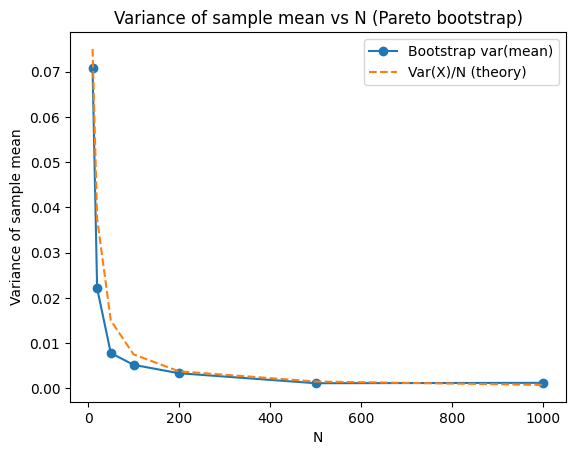

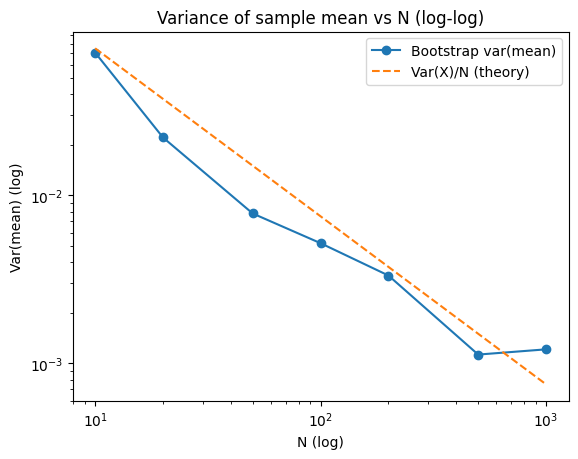

In [8]:
# Plots (each in its own figure)
plt.figure()
plt.plot(results["N"], results["boot_var_mean"], marker="o", label="Bootstrap var(mean)")
if not np.isnan(var_th):
    plt.plot(results["N"], results["theoretical_var_of_mean"], linestyle="--", label="Var(X)/N (theory)")
plt.title("Variance of sample mean vs N (Pareto bootstrap)")
plt.xlabel("N")
plt.ylabel("Variance of sample mean")
plt.legend()
plt.show()

plt.figure()
plt.loglog(results["N"], results["boot_var_mean"], marker="o", label="Bootstrap var(mean)")
if not np.isnan(var_th):
    plt.loglog(results["N"], results["theoretical_var_of_mean"], linestyle="--", label="Var(X)/N (theory)")
plt.title("Variance of sample mean vs N (log-log)")
plt.xlabel("N (log)")
plt.ylabel("Var(mean) (log)")
plt.legend()
plt.show()

For a Pareto with finite variance (α>2), he variance of the sample mean gets smaller as 𝑁 increases, decreasing approximately like 1/𝑁 (it lines up with the dashed Var(𝑋)/𝑁 reference).If you set 𝛼≤2(very heavy tails), the variance is infinite theoretically; bootstrap estimates become unstable and do not follow clean 1/𝑁 decay.